<a href="https://colab.research.google.com/github/PuchToTalk/LLM/blob/main/Finetune_opt_peft_Databricks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fine-tune large models using 🤗 `peft` adapters, `transformers` & `bitsandbytes`

Applying the utorial to fine-tune large language models using the very recent `peft` library and `bitsandbytes` for loading large models in 8-bit.
The fine-tuning method will rely on the "Low Rank Adapters" (LoRA) method, instead of fine-tuning the entire model we just have to fine-tune these adapters and load them properly inside the model.
After fine-tuning the model you can also share your adapters on the 🤗 Hub and load them very easily!

### Install requirements

First, run the cells below to install the requirements:

In [1]:
!pip install -q bitsandbytes datasets accelerate loralib
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git
!pip install bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 34.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.9 MB/s eta 0

### Model loading

Here let's load the `opt-6.7b` model, its weights in half-precision (float16) are about 13GB on the Hub! If we load them in 8-bit we would require around 7GB of memory instead.

In [2]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            83Gi       1.2Gi        78Gi       3.0Mi       3.5Gi        81Gi
Swap:             0B          0B          0B


In [3]:
!nvidia-smi

Sat Oct 21 06:57:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    43W / 350W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    "facebook/opt-6.7b",
    load_in_8bit=True,
    device_map='auto',
)

tokenizer = AutoTokenizer.from_pretrained("facebook/opt-6.7b")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Post-processing on the model

Finally, we need to apply some post-processing on the 8-bit model to enable training, let's freeze all our layers, and cast the layer-norm in `float32` for stability. We also cast the output of the last layer in `float32` for the same reasons.

In [5]:
for param in model.parameters():
  param.requires_grad = False  # freeze the model - train adapters later
  if param.ndim == 1:
    # cast the small parameters (e.g. layernorm) to fp32 for stability
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()  # reduce number of stored activations
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

### Apply LoRA

Here comes the magic with `peft`! Let's load a `PeftModel` and specify that we are going to use low-rank adapters (LoRA) using `get_peft_model` utility function from `peft`.

In [6]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [7]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 8388608 || all params: 6666862592 || trainable%: 0.12582542214183376


### Training

In [8]:
import transformers
from datasets import load_dataset
#data = load_dataset("Abirate/english_quotes")
data = load_dataset("databricks/databricks-dolly-15k")
#data = data.map(lambda samples: tokenizer(samples['quote']), batched=True)
data = data.map(lambda samples: tokenizer(samples['response']), batched=True)


trainer = transformers.Trainer(
    model=model,
    train_dataset=data['train'],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=100,
        max_steps=200,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        output_dir='outputs'
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/15011 [00:00<?, ? examples/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss
1,2.650800
2,2.637100
3,2.713600
4,2.482000
5,2.558200
6,2.941400
7,2.406600
8,2.397700
9,2.409900
10,2.436000


TrainOutput(global_step=200, training_loss=2.4689350652694704, metrics={'train_runtime': 1059.4904, 'train_samples_per_second': 3.02, 'train_steps_per_second': 0.189, 'total_flos': 2.263978416734208e+16, 'train_loss': 2.4689350652694704, 'epoch': 0.21})

In [9]:
model.save_pretrained("output_dir")

## Share adapters on the 🤗 Hub

In [10]:
from huggingface_hub import notebook_login

notebook_login()

In [11]:
model.push_to_hub("Puch/Databricks-lora", use_auth_token=True)

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:844: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


adapter_model.bin:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Puch/Databricks-lora/commit/3235c6e4594f8ffa8c42ecdbc503496adca4efa6', commit_message='Upload model', commit_description='', oid='3235c6e4594f8ffa8c42ecdbc503496adca4efa6', pr_url=None, pr_revision=None, pr_num=None)

## Load adapters from the Hub

You can also directly load adapters from the Hub using the commands below:

In [12]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

peft_model_id = "Puch/Databricks-lora"
config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path, return_dict=True)


tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

# Load the Lora model
model = PeftModel.from_pretrained(model, peft_model_id)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Inference

You can then directly use the trained model or the model that you have loaded from the 🤗 Hub for inference as you would do it usually in `transformers`.

In [13]:
batch = tokenizer("Why mobile is bad for human? ", return_tensors='pt')

with torch.cuda.amp.autocast():
  output_tokens = model.generate(**batch, max_new_tokens=50)

print('\n\n', tokenizer.decode(output_tokens[0], skip_special_tokens=True))



 Why mobile is bad for human? 

Mobile is bad for human because it is bad for human's health. Mobile is bad for human's health because it is bad for human's health. Mobile is bad for human's health because it is bad for human's health. Mobile is


After finetuning a few steps, we got a pretty decent result from the initial [training data](https://huggingface.co/datasets/databricks/databricks-dolly-15k?row=8).

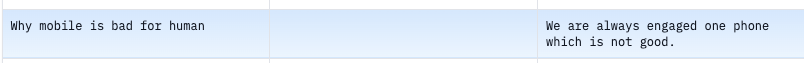